In [19]:
from qiskit import *

In [20]:
#define ansatz
def ansatz(params):
    qreg = QuantumRegister(2)
    creg = ClassicalRegister(2)
    qc = QuantumCircuit(qreg, creg)
    
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    
    qc.rx(params[2], 1)
    qc.ry(params[3], 1)
    
    qc.cx(0, 1)
    
    return qc

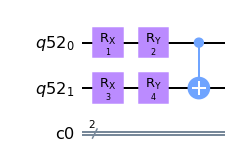

In [21]:
#get the trial state

parameters = [1,2,3,4]
qcirc = ansatz(parameters)
qcirc.draw("mpl")

In [22]:
from qiskit import execute, Aer
job = execute(qcirc, Aer.get_backend('statevector_simulator'))
trial_state = job.result().get_statevector(qcirc, decimals = 3)
print("Trial state:",trial_state)

Trial state: [-0.38 +0.418j  0.155+0.29j  -0.137+0.223j  0.213+0.677j]


C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\aer\backends\aerbackend.py:87: DeprecationWarning: The BaseBackend abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the BackendV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(configuration, provider=provider)
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\aer\aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)


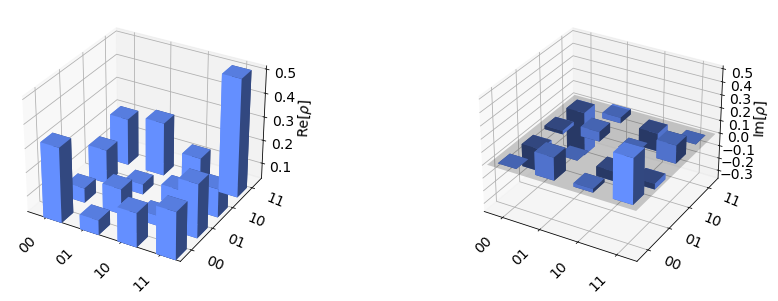

In [23]:
from qiskit.visualization import plot_state_city
plot_state_city(trial_state)

In [24]:
def vqe_ansatz(params):
    qc = ansatz(params)
    qc.measure([0,1], [0,1])
    return qc

In [25]:
qcirc = vqe_ansatz(parameters)
job = execute(qcirc, Aer.get_backend('qasm_simulator'), shots=2048)
counts = job.result().get_counts(qcirc)
print(counts)

{'00': 635, '01': 228, '10': 134, '11': 1051}


In [26]:
#calculate expected value
# Any state can be expressed as a linear combination of |00>, |01>, |10>, |11> and 
# their eigenvalues are 1,-1,-1,1 respectively using which the expectation value is computed

def expectation_value(counts):
    
    sum = 0
    for i in counts:
        sum += counts[i]
    
    expected_val = 0
    for i in counts:
        if i=='00' or i=='11':
            expected_val += counts[i]
        else:
            expected_val -= counts[i]
    expected_val = expected_val/sum
    
    return expected_val

print("Expected energy for trial state:",expectation_value(counts))

Expected energy for trial state: 0.646484375


In [27]:
#get exact ground state energy

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.algorithms import NumPyEigensolver

def hamiltonian_ZxZ():
    pauli_dict = {
        'paulis': [
            {'coeff': {'real': 1, 'imag': 0}, 'label': 'ZZ'}
        ]
    }
    return WeightedPauliOperator.from_dict(pauli_dict)

H = hamiltonian_ZxZ()
exact_res = NumPyEigensolver(H).run()
ground_energy = min(np.real(exact_res.eigenvalues))
print("The exact ground state energy is:", format(ground_energy))

The exact ground state energy is: -1.0


C:\ProgramData\Anaconda3\lib\site-packages\qiskit\aqua\operators\primitive_ops\pauli_op.py:163: DeprecationWarning: `to_spmatrix` is deprecated and will be removed no earlier than 3 months after the release date. Use `to_matrix(sparse=True)` instead.
  return self.primitive.to_spmatrix() * self.coeff  # type: ignore


In [28]:
#optimization - classical computing approach

from scipy.optimize import minimize

def vqe(parameters):
    qc = ansatz(parameters)
    qc.measure([0,1],[0,1])
    job = execute(qc, Aer.get_backend('qasm_simulator'), shots=4096)
    counts = job.result().get_counts(qc)
    return expectation_value(counts)

parameters = [np.pi, np.pi/2, np.pi/2, np.pi]
parameters = [10,20,30,40]
tolerance = 1e-5

In [30]:
vqe_result_cob = minimize(vqe, parameters, tol = tolerance)
print("No method specified: The estimated ground state energy is:", format(vqe_result_cob.fun))

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\aer\backends\aerbackend.py:87: DeprecationWarning: The BaseBackend abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the BackendV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(configuration, provider=provider)
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\aer\aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\aer\backends\aerbackend.py:87: DeprecationWarning: The BaseBackend abstract interface is deprecated as of the 0.18.0 release and will be removed i

No method specified: The estimated ground state energy is: -0.13232421875


In [31]:
vqe_result_cob = minimize(vqe, parameters, method="COBYLA", tol = tolerance)
print("COBYLA: The estimated ground state energy is:", format(vqe_result_cob.fun))

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\aer\backends\aerbackend.py:87: DeprecationWarning: The BaseBackend abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the BackendV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(configuration, provider=provider)
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\aer\aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)


COBYLA: The estimated ground state energy is: -0.99951171875


In [32]:
vqe_result_pow = minimize(vqe, parameters, method="Powell", tol = tolerance)
print("Powell: The estimated ground state energy is:", format(vqe_result_pow.fun))

Powell: The estimated ground state energy is: -1.0
